In [1]:
from Bio import SeqIO
import matplotlib.pyplot as plt
from Bio.Seq import Seq
import pandas as pd
import numpy as np

In [28]:
class DotMatrixAlignment:
    def __init__(self, **kwargs):
        self.seq1 = SeqIO.read(kwargs["input_sequence_1"], "fasta").seq
        self.seq2 = SeqIO.read(kwargs["input_sequence_2"], "fasta").seq

        score_matrix = {"match": 2, "mismatch": -1}
        self.score_matrix = (
            pd.read_csv(kwargs["score_matrix"]).iloc[0]
            if kwargs["score_matrix"] != ""
            else score_matrix
        )

        self.window_size = (
            int(kwargs["window_size"]) if kwargs["window_size"] != "" else 10
        )
        self.threshold = int(kwargs["threshold"]) if kwargs["threshold"] != "" else 15
        self.x1 = int(kwargs["x1"]) - 1 if kwargs["x1"] != "" else 0
        self.x2 = int(kwargs["x2"]) - 1 if kwargs["x2"] != "" else 99
        self.y1 = int(kwargs["y1"]) - 1 if kwargs["y1"] != "" else 0
        self.y2 = int(kwargs["y2"]) - 1 if kwargs["y2"] != "" else 99

        self.graphic_title = kwargs["graphic_title"]
        self.graphic_subtitle = kwargs["graphic_subtitle"]
        self.x_axis_title = kwargs["x_axis_title"]
        self.y_axis_title = kwargs["y_axis_title"]
        self.file_name = kwargs["file_name"]

        self.coordinates = []

        self.lines = []

    def get_score(self, seq1, seq2):
        score = 0
        match_ids = []

        for i in range(self.window_size):
            if seq1[i] == seq2[i]:
                score += self.score_matrix["match"]
                match_ids += [i]
            else:
                score += self.score_matrix["mismatch"]

        return score, match_ids

    def add_line(self, x1, y1):
        x2 = x1 + self.window_size - 1
        y2 = y1 + self.window_size - 1
        a = (y1 - y2) / (x1 - x2)
        b = y1 - (x1 * a)
        new_line = {
            "first": (x1, y1),
            "last": (x2, y2),
            "a": a,
            "b": b,
        }
        self.lines.append(new_line)

    def handle_lines(self, x1, y1):
        if len(self.lines) == 0:
            self.add_line(x1, y1)
        else:
            for line in self.lines:  # loop through lines
                if (
                    y1 == line["a"] * x1 + line["b"]
                ):  # if belong to line, check append line (concat or ignore)
                    if line["last"][0] + 5 >= x1:  # belong to line, concat
                        line["last"] = (
                            x1 + self.window_size - 1,
                            y1 + self.window_size - 1,
                        )
                        return

            self.add_line(x1, y1)

    def get_alignment(self):
        for i in range(self.x1, self.x2 - self.window_size + 2):
            for j in range(self.y1, self.y2 - self.window_size + 2):
                score, match_ids = self.get_score(
                    self.seq1[i : i + self.window_size],
                    self.seq2[j : j + self.window_size],
                )

                if score >= self.threshold:
                    self.handle_lines(i, j)
                    for idx in match_ids:
                        x_coor = i + idx
                        y_coor = j + idx

                        if (x_coor, y_coor) not in self.coordinates:
                            self.coordinates.append((x_coor, y_coor))

    def plot(self):
        self.get_alignment()

        x_coors = []
        y_coors = []
        for x_coor, y_coor in self.coordinates:
            x_coors.append(x_coor)
            y_coors.append(y_coor)

        plt.figure(figsize=(10, 10))
        plt.xlim(self.x1 - 10, self.x2 + 10)
        plt.ylim(self.y1 - 10, self.y2 + 10)
        plt.xlabel(self.x_axis_title, fontsize=12)
        plt.ylabel(self.y_axis_title, fontsize=12)
        plt.suptitle(self.graphic_title, fontsize=14)
        plt.title(
            f"{self.graphic_subtitle}\nWindow size: {self.window_size}, threshold: {self.threshold}",
            fontsize=12,
        )

        plt.scatter(x_coors, y_coors, s=3, c="red")
        if self.lines != 0:
            for line in self.lines:
                plt.plot(
                    [line["first"][0], line["last"][0]],
                    [line["first"][1], line["last"][1]],
                    linewidth=1,
                    c="green",
                )
        plt.savefig(self.file_name)
        plt.show()
        print(f"There are {len(self.lines)} lines")

In [14]:
df = pd.read_csv("config.csv")
df.fillna("", inplace=True)
df

,input_sequence_1,input_sequence_2,score_matrix,window_size,threshold,graphic_title,graphic_subtitle,x_axis_title,y_axis_title,x1,x2,y1,y2,file_name
0,virus_datasets/covid_sequences.fasta,virus_datasets/covid_sequences.fasta,score_matrix.csv,10.0,15.0,Covid vs Covid,Ma trận bộ gen,Covid,Covid,100.0,200.0,100.0,200.0,covid-ebola.png
1,virus_datasets/covid_sequences.fasta,virus_datasets/ebola_sequence.fasta,score_matrix.csv,10.0,15.0,Covid vs Ebola,Ma trận bộ gen,Covid,Ebola,1.0,200.0,1.0,200.0,covid-ebola.png
2,virus_datasets/covid_sequences.fasta,virus_datasets/hiv_sequence.fasta,,,12.0,Covid vs HIV,,,,,,,,covid-hiv.png
3,virus_datasets/covid_sequences.fasta,virus_datasets/mers_sequence.fasta,,,,Covid vs Mers,,,,,,,,covid-mers.png
4,virus_datasets/covid_sequences.fasta,virus_datasets/sars_sequence.fasta,,,,Covid vs Sars,,,,,,,,covid-sars.png


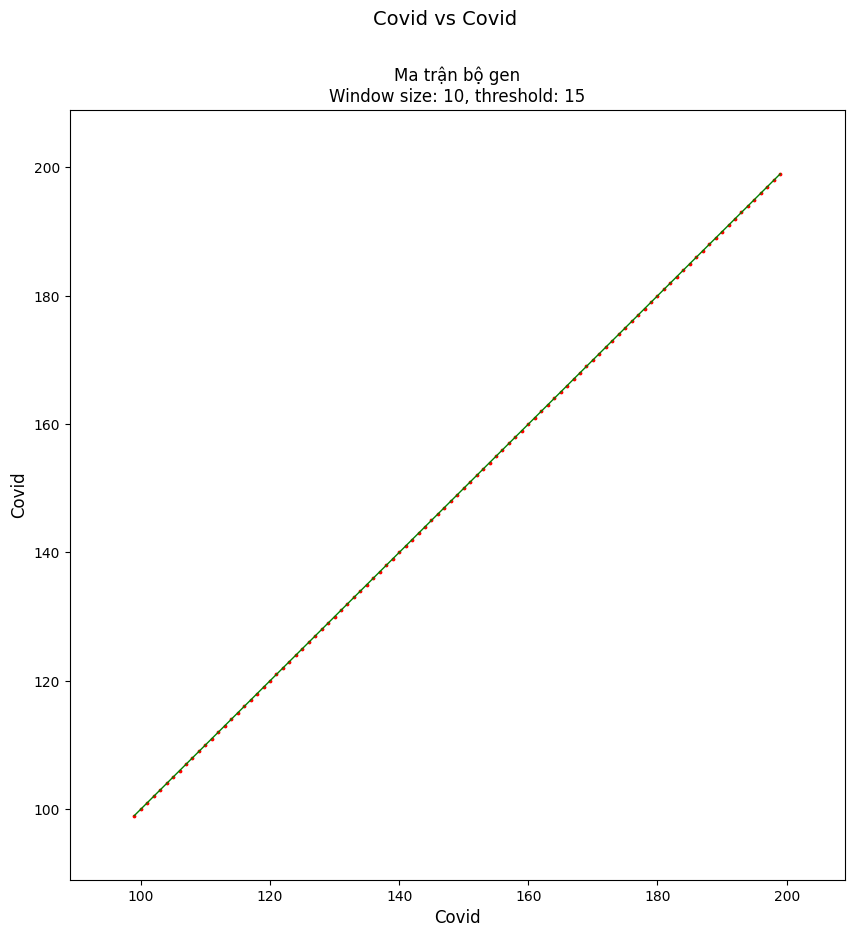

There are 1 lines


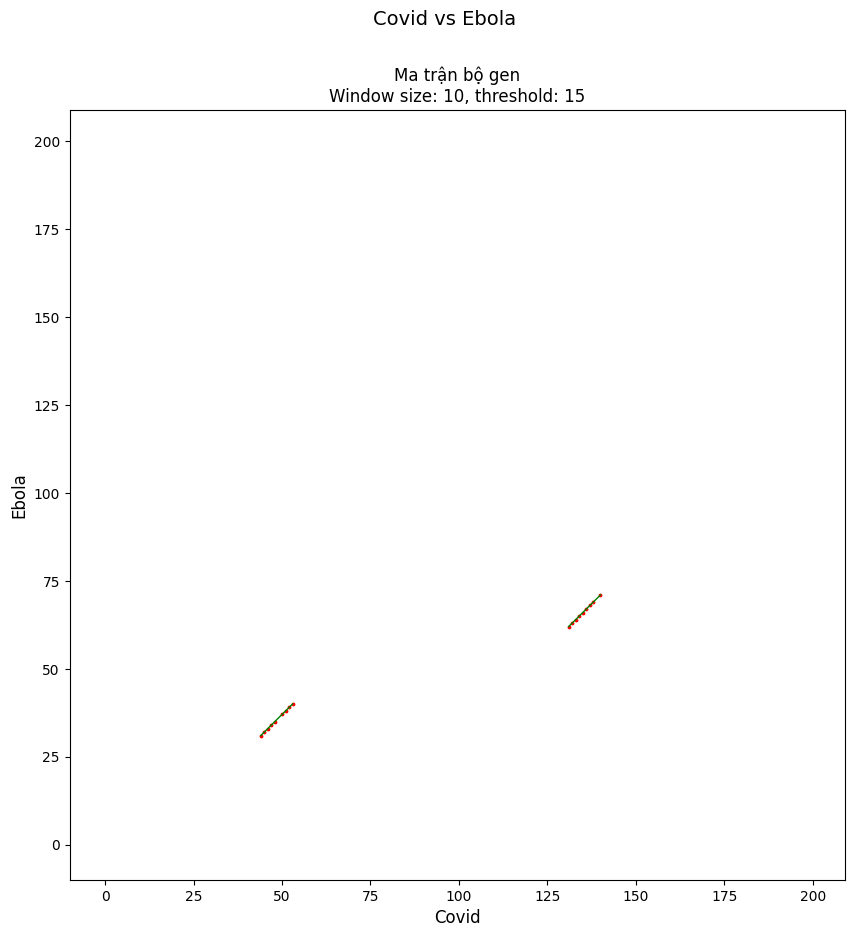

There are 2 lines


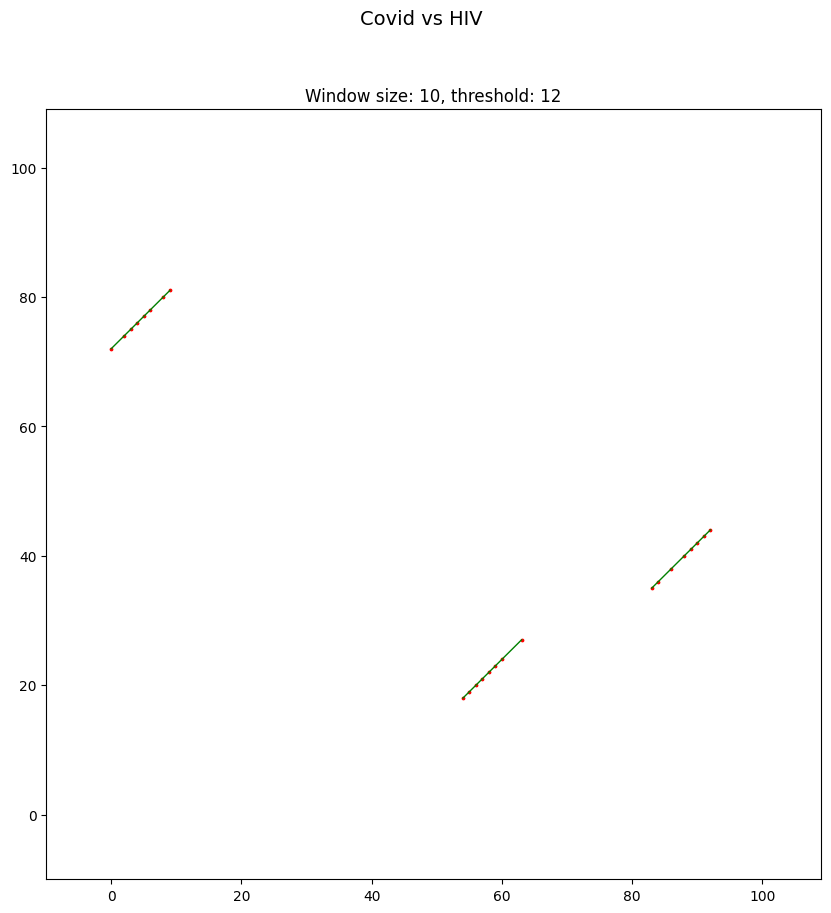

There are 3 lines


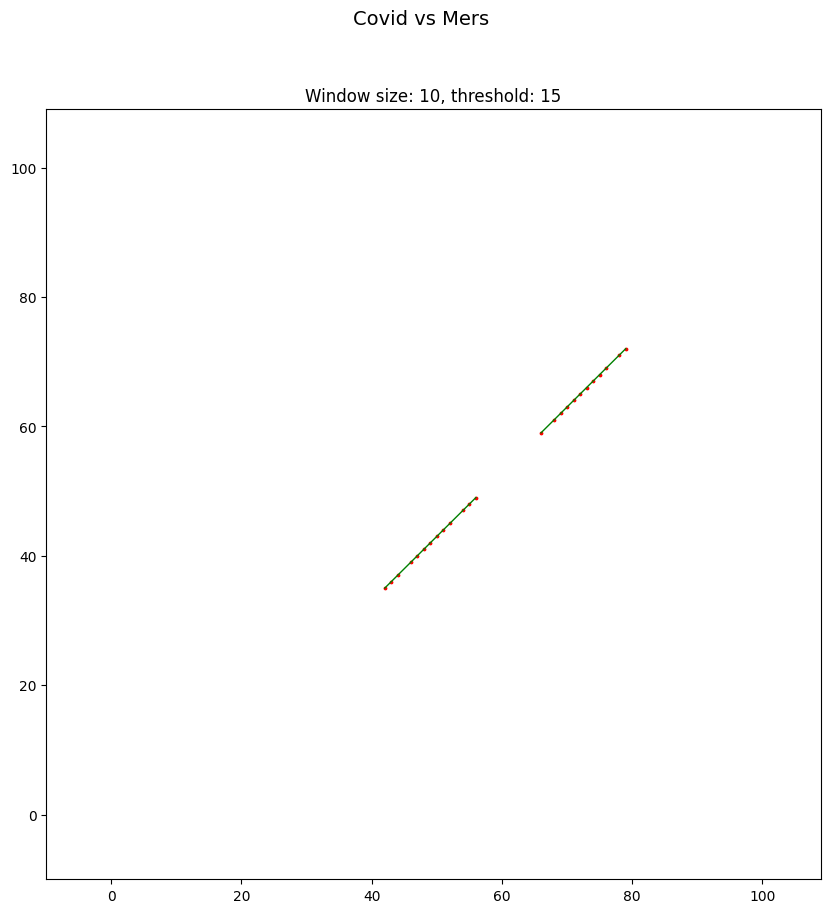

There are 2 lines


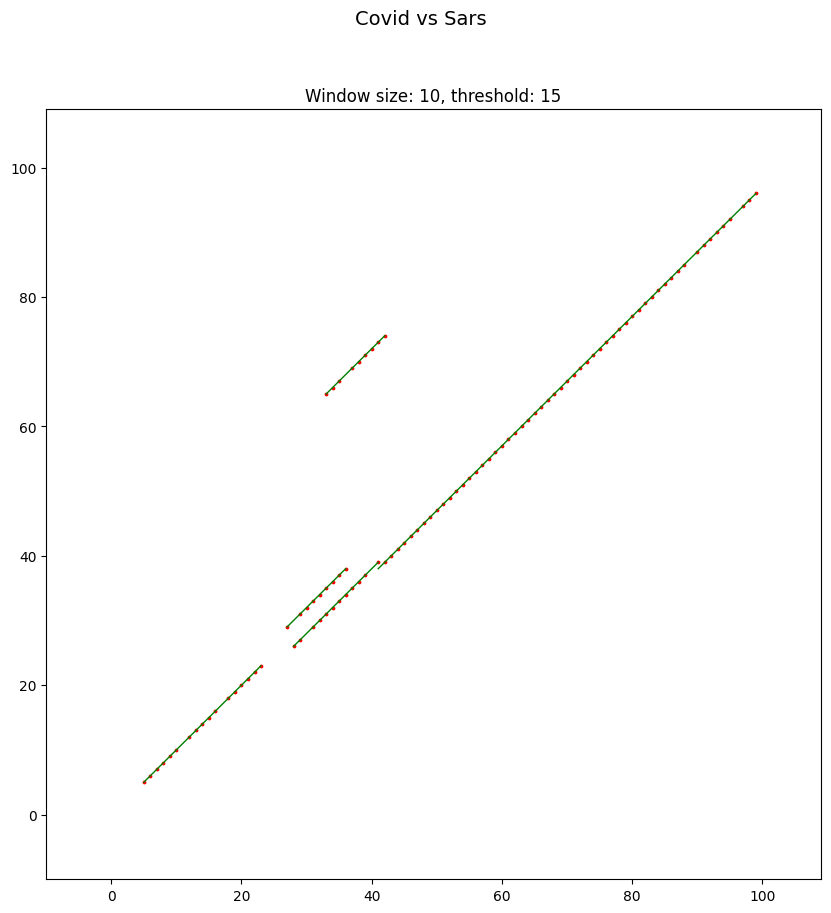

There are 5 lines


In [29]:
for idx in df.index:
    record = df.iloc[idx].to_dict()

    obj = DotMatrixAlignment(**record)

    obj.plot()
    